# Plot $R_0$, infected and susceptible fraction for ENSO event composites as timeseries
### MERRA-2 specific humidity-forced SIRS model with HCoV-HKU1 parameters

## For individual locations in Australia, Brazil

Last updated August 22 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#define figure resolution
plt.rcParams['figure.dpi'] = 250

/home/mvchung/anaconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
# specify the time resolution of the MERRA-2 data that was used to force the SIRS model
res = 'weekly' # daily # weekly

In [3]:
# load data
# LAT: 361, LON: 576, month: 12, year: # events

# year 0
ElNino_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_allevents.nc")
LaNina_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_allevents.nc")
Neutral_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_allevents.nc")

# year +1
ElNino_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_1_allevents.nc")
LaNina_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_1_allevents.nc")
Neutral_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_1_allevents.nc")

# year +2
ElNino_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_2_allevents.nc")
LaNina_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_2_allevents.nc")
Neutral_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_2_allevents.nc")

HKU1 = xr.open_dataset(f"./data_{res}/HKU1_yearmonth.nc") # monthly mean data

climatology = HKU1.mean('year')

ds = xr.open_dataset(f'./data_{res}/HKU1_monthly_mean.nc')


/home/mvchung/anaconda3/lib/python3.7/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# look at the data
ElNino_allevents

<xarray.Dataset>
Dimensions:  (LAT: 361, LON: 576, month: 12, year: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * LAT      (LAT) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * LON      (LON) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * year     (year) int64 1982 1986 1987 1991 1994 ... 2004 2006 2009 2014 2015
Data variables:
    IT       (year, month, LAT, LON) float32 ...
    ST       (year, month, LAT, LON) float32 ...
    R0       (year, month, LAT, LON) float32 ...

In [5]:
# Create ENSO event composites and put them in a timeseries from year 0 to year +2 (36 months)

def comp_ts(ElNino_yr0, ElNino_yr1, ElNino_yr2):
    # composite and convert to timeseries of year 0, +1, +2
    
    # concatenate original data
    
    
    # for R0, IF, SF
    comp0 = ElNino_yr0.mean('year') # composites
    comp1 = ElNino_yr1.mean('year')
    comp2 = ElNino_yr2.mean('year')
    
    timeseries = xr.concat([comp0,comp1,comp2], dim='month') # concatenate
    timeseries['month'] = np.arange(1,37) # convert months to 1-36
    
    # for confidence intervals
    CI_0 = 1.96 * ElNino_yr0.std('year') / np.sqrt(ElNino_yr0.year.size)
    CI_1 = 1.96 * ElNino_yr1.std('year') / np.sqrt(ElNino_yr1.year.size)
    CI_2 = 1.96 * ElNino_yr2.std('year') / np.sqrt(ElNino_yr2.year.size)
    
    CI_ts = xr.concat([CI_0, CI_1, CI_2], dim='month') # concatenate
    CI_ts['month'] = np.arange(1,37) # convert months to 1-36
    
    return timeseries, CI_ts

ElNino_comp_ts, ElNino_CI_ts = comp_ts(ElNino_allevents,ElNino_1_allevents,ElNino_2_allevents)
LaNina_comp_ts, LaNina_CI_ts = comp_ts(LaNina_allevents,LaNina_1_allevents,LaNina_2_allevents)
Neutral_comp_ts, Neutral_CI_ts = comp_ts(Neutral_allevents,Neutral_1_allevents,Neutral_2_allevents)

In [6]:
# concatenate climatology 3 times
clim_ts = xr.concat([climatology,climatology,climatology], dim='month')
clim_ts['month'] = ElNino_CI_ts.month

# Plotting functions

In [7]:
def plot_ts(ax, x, y, CI, color='k', label='', ylim=None):
    y.plot(ax=ax, color=color, label=label)
    ax.fill_between(x, y+CI, y-CI, color=color, alpha=0.2, edgecolor=None)
    if ylim != None:
        ax.set_ylim(ylim)

In [8]:
def plot_comp_timeseries(lon, lat,
                         ElNino_comp_ts,LaNina_comp_ts,
                         ElNino_CI_ts,LaNina_CI_ts,
                        clim_ts, Neutral_comp_ts,
                         location_name='NW Australia',neutral=True):
    x = ElNino_CI_ts.month

    #lon, lat = 128, -18 # choose a location
    
    variables = ['R0','IT','ST']
    titles = [r'$R_0$','Infected','Susceptible']

    xlabels = ['J','F','M','A','M','J','J','A','S','O','N','D',
              'J','F','M','A','M','J','J','A','S','O','N','D',
              'J','F','M','A','M','J','J','A','S','O','N','D',]

    fig, ax = plt.subplots(3,1, figsize=(10,6), constrained_layout=True, sharex=False)


    for ii in range(np.size(variables)):

        variable = variables[ii]

        # El Niño
        y = ElNino_comp_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
        CI = ElNino_CI_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
        plot_ts(ax[ii],x,y,CI,'r', 'El Niño year')

        # La Niña
        y = LaNina_comp_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
        CI = LaNina_CI_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
        plot_ts(ax[ii],x,y,CI,'b', 'La Niña year')

        # climatology
        ax[ii].plot(x, clim_ts[variable].sel(LON=lon,LAT=lat,method='nearest'),
                    linestyle='--',color='k', label='average year')
        
        if neutral==True:
            # Neutral
            y = Neutral_comp_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
            CI = Neutral_CI_ts[variable].sel(LON=lon,LAT=lat,method='nearest')
            plot_ts(ax[ii],x,y,CI,'darkgreen', 'Neutral year')
            #ax[ii].plot(x, Neutral_comp_ts[variable].sel(LON=lon,LAT=lat,method='nearest'),
            #            linestyle='--',color='darkgreen', label='Neutral avg')

        # misc.
        ax[ii].grid(linestyle='--')
        ax[ii].set_title('')
        ax[ii].set_xlabel('')
        ax[ii].set_ylabel(titles[ii],fontsize=20)
        ax[ii].set_xticks(x)
        ax[ii].set_xticklabels(xlabels)
        ax[ii].axvline(13,color='grey',zorder=1)
        ax[ii].axvline(25,color='grey',zorder=1)
        ax[ii].set_xlim(1,36)
        if variable == 'IT':
            ax[ii].set_ylim(0,None)

    # misc. plotting
    fig.text(0.37, -0.03, 'Year 0', ha='center', fontsize=14)
    fig.text(0.63, -0.03, 'Year +1', ha='center', fontsize=14)
    fig.text(0.88, -0.03, 'Year +2', ha='center', fontsize=14)
    fig.suptitle(f'{location_name} ENSO-disease composites',fontsize=20)
    #ax[0].legend(loc='lower right')
    ax[0].legend(loc='upper right', bbox_to_anchor=(-0.1, 1.0), fontsize=12)

In [9]:
def plot_ts_ENSOevents(lon,lat,
                       ds,
                       ElNino_allevents,LaNina_allevents):

    temp = ds.sel(LON=lon, LAT=lat, method='nearest')

    fig, ax = plt.subplots(3,1,figsize=(10,4), sharex=True, constrained_layout=True)

    variables = ['R0','IT','ST']
    titles = [f'$R_0$','Infected fraction','Susceptible fraction']

    for ii in range(np.size(ax.flatten())):
        axis = ax.flatten()[ii]
        temp[variables[ii]].plot(ax=axis, color='k')
        axis.set_title(titles[ii])
        axis.set_xlabel('')
        axis.set_ylabel('')
        axis.set_xlim(np.datetime64('1981-01-31', 'ns'),np.datetime64('2017-12-31', 'ns'))
        
        if variables[ii] == 'IT':
            axis.set_ylim(0,None)
        
        # plot the ENSO years
        for year in ElNino_allevents.year.values:
            year = int(year)
            axis.axvspan(f'{year}-01-01', f'{year}-12-31', alpha=0.2, color='r')
        for year in LaNina_allevents.year.values:
            year = int(year)
            axis.axvspan(f'{year}-01-01', f'{year}-12-31', alpha=0.2, color='b')
    

In [10]:
def ts_plots(lon, lat, ElNino_allevents, ElNino_1_allevents, ElNino_2_allevents,
             LaNina_allevents, LaNina_1_allevents, LaNina_2_allevents,
             Neutral_allevents, Neutral_1_allevents, Neutral_2_allevents,
             climatology):
    
    # figure 1
    plt.figure(figsize=(5,3))

    x0 = np.arange(1,13)
    x1 = np.arange(13,25)
    x2 = np.arange(25,37)
    
    def myplot(x, allevents, lon, lat, label='', color='r'):
        for ii in range(np.size(allevents.year)):
            
            temp = allevents.sel(LAT=lat,LON=lon, method='nearest')
            y = temp.IT.isel(year=ii)
            ymean = temp.IT.mean('year')
            
            plt.plot(x,y,color=color, alpha=0.2)
        plt.plot(x,ymean, color=color, label=label,linestyle='--')
    
    myplot(x0, ElNino_allevents, lon, lat, label='El Niño')
    myplot(x1, ElNino_1_allevents, lon, lat, label='El Niño')
    myplot(x2, ElNino_2_allevents, lon, lat, label='El Niño')
    
    myplot(x0, LaNina_allevents, lon, lat, label='La Niña', color='b')
    myplot(x1, LaNina_1_allevents, lon, lat, label='La Niña', color='b')
    myplot(x2, LaNina_2_allevents, lon, lat, label='La Niña', color='b')
    
    myplot(x0, Neutral_allevents, lon, lat, label='Neutral', color='darkgreen')
    myplot(x1, Neutral_1_allevents, lon, lat, label='Neutral', color='darkgreen')
    myplot(x2, Neutral_2_allevents, lon, lat, label='Neutral', color='darkgreen')

    clim = climatology.sel(LAT=lat,LON=lon, method='nearest').IT
    plt.plot(x0,clim, color='k', label='clim')
    plt.plot(x1,clim, color='k', label='clim')
    plt.plot(x2,clim, color='k', label='clim')

    #plt.legend()

    # figure 2
    fig, axes = plt.subplots(1,3,figsize=(10,3), constrained_layout=True, sharey=True)

    for ii in range(np.size(ElNino_allevents.year)):
        y = ElNino_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.isel(year=ii)
        ymean = ElNino_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.mean('year')
        axes[0].plot(y,color='r',label='El Niño', alpha=0.2)
        axes[0].plot(ymean, color='r', linestyle='--')

    for ii in range(np.size(LaNina_allevents.year)):
        y = LaNina_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.isel(year=ii)
        ymean = LaNina_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.mean('year')
        axes[1].plot(y,color='b',label='La Niña', alpha=0.2)
        axes[1].plot(ymean, color='b', linestyle='--')

    for ii in range(np.size(Neutral_allevents.year)):
        y = Neutral_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.isel(year=ii)
        ymean = Neutral_allevents.sel(LAT=lat,LON=lon, method='nearest').IT.mean('year')
        axes[2].plot(y, color='darkgreen', label= 'Neutral', alpha = 0.2)
        axes[2].plot(ymean, color='darkgreen', linestyle='--')

    for axis in axes.flatten():
        axis.plot(climatology.sel(LAT=lat,LON=lon, method='nearest').IT, color='k')

    axes[0].set_title('El Niño')
    axes[1].set_title('La Niña')
    axes[2].set_title('Neutral')

# NW Australia

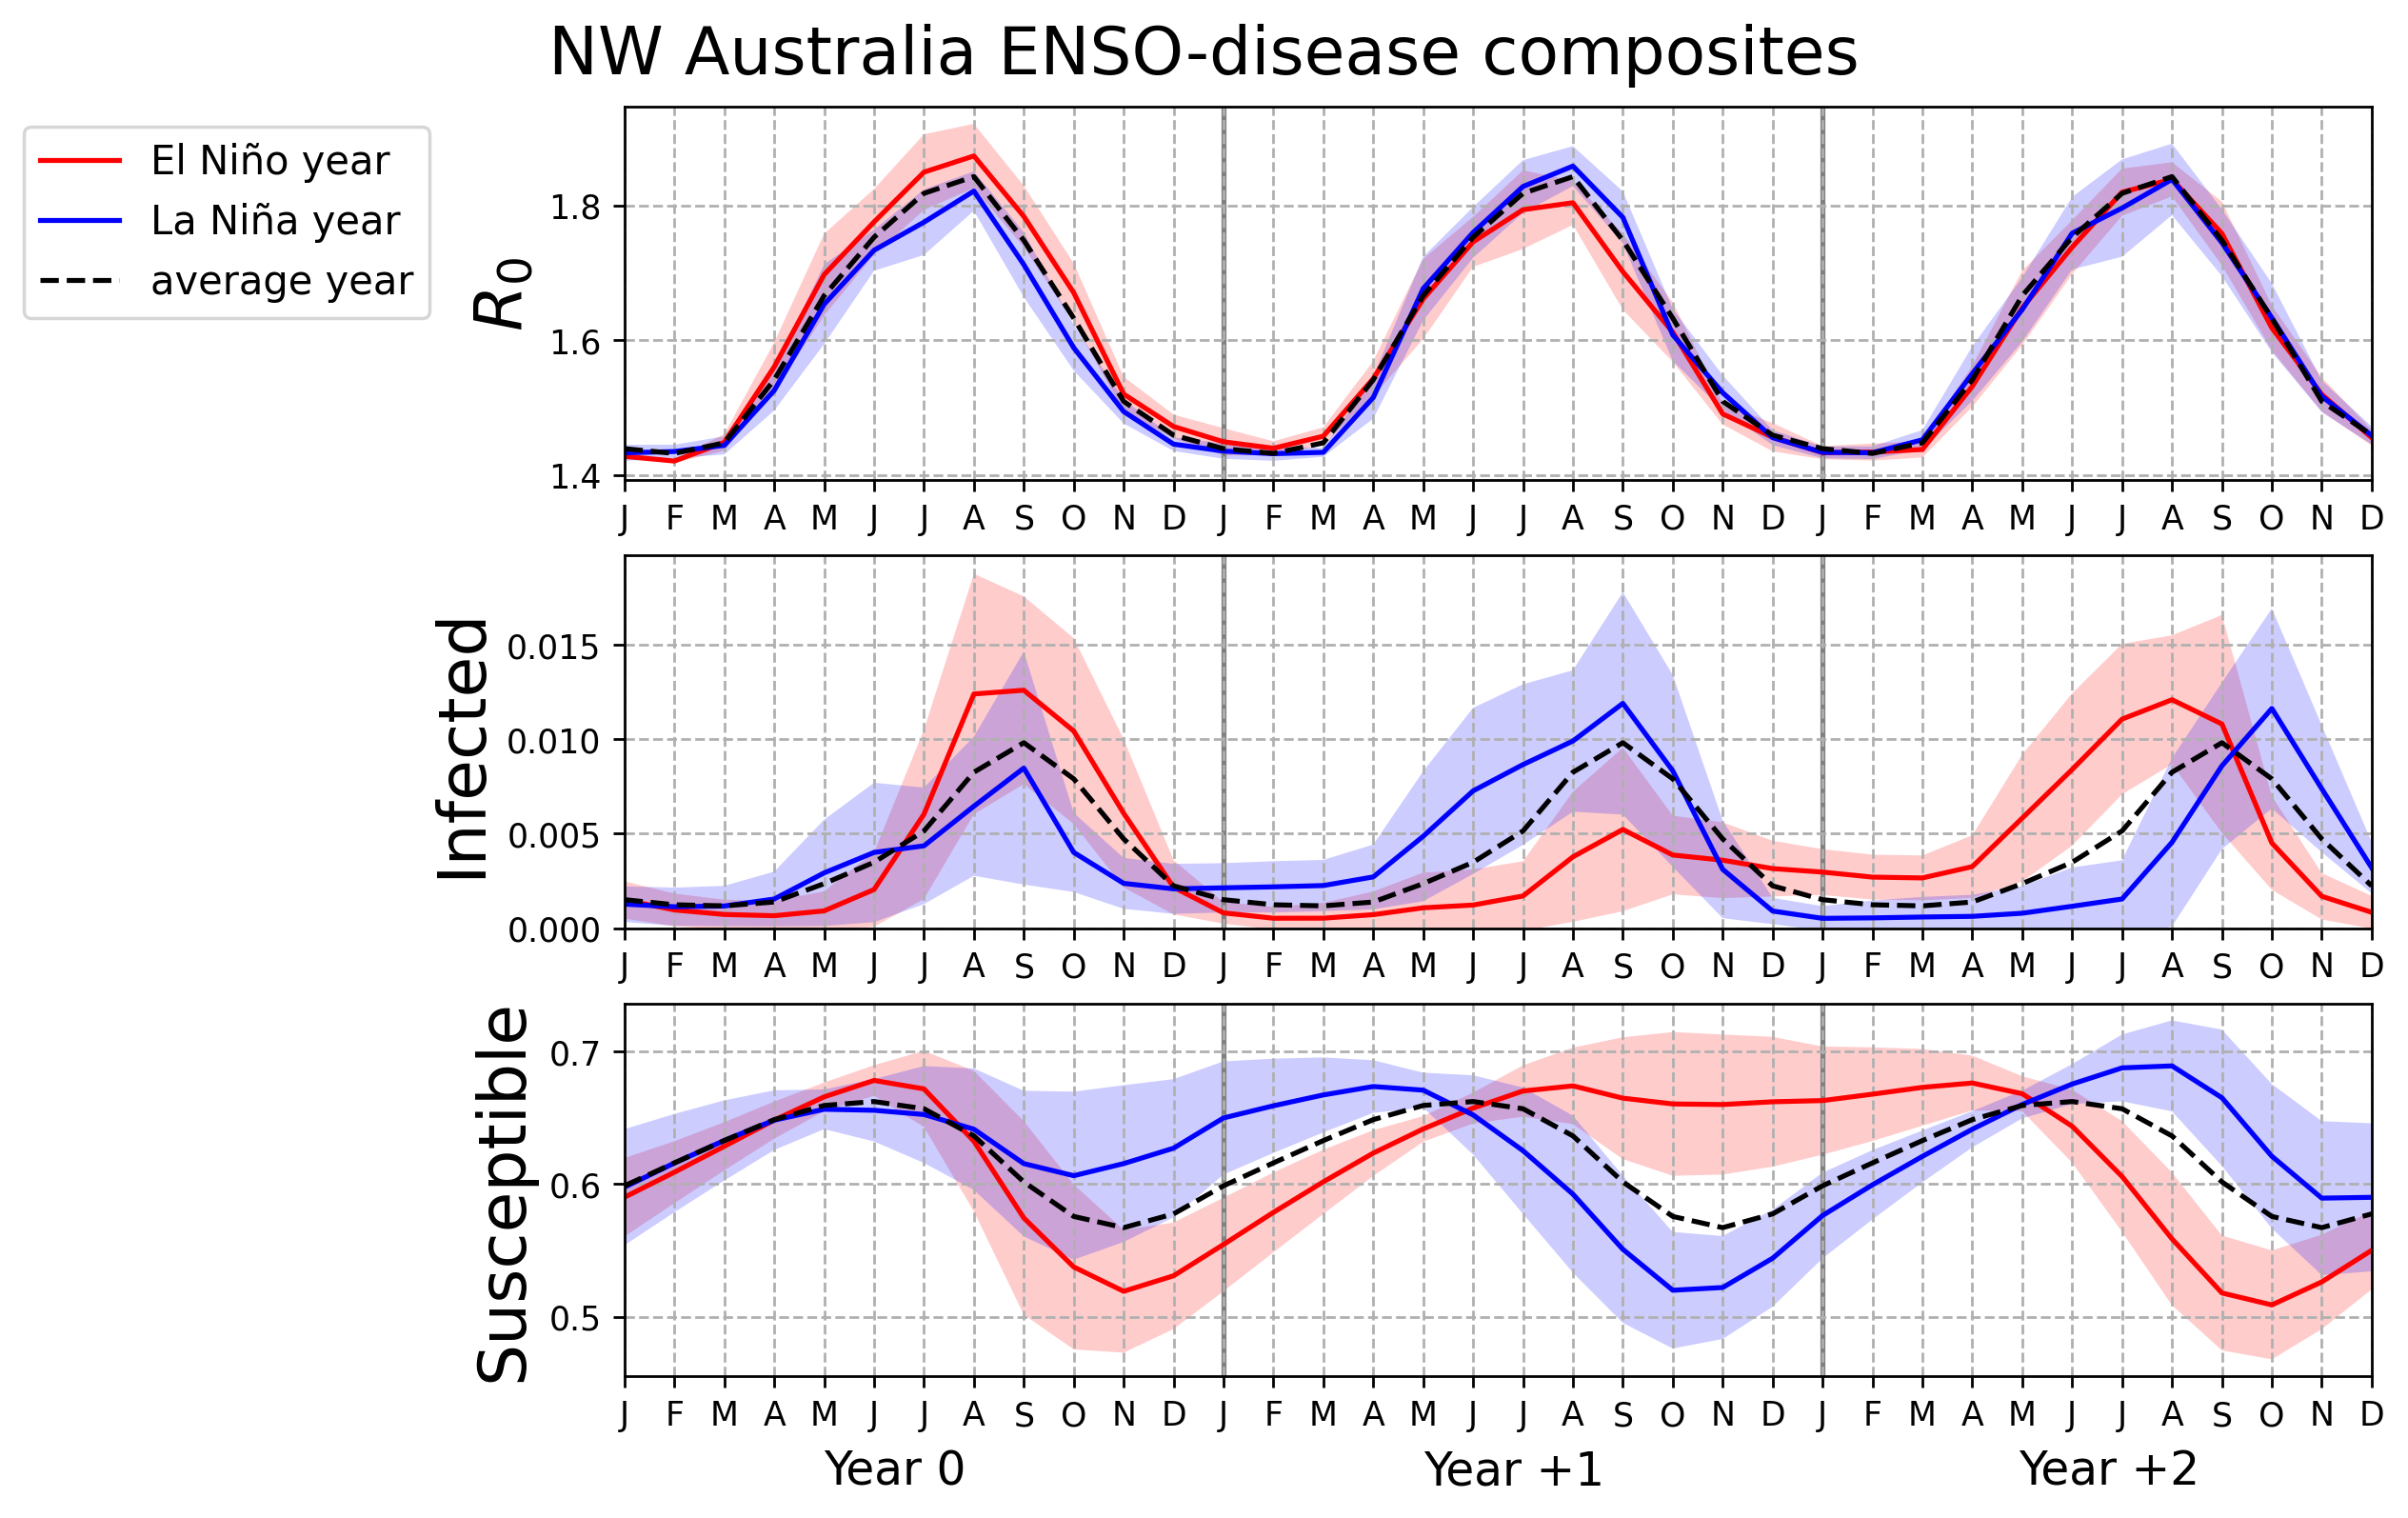

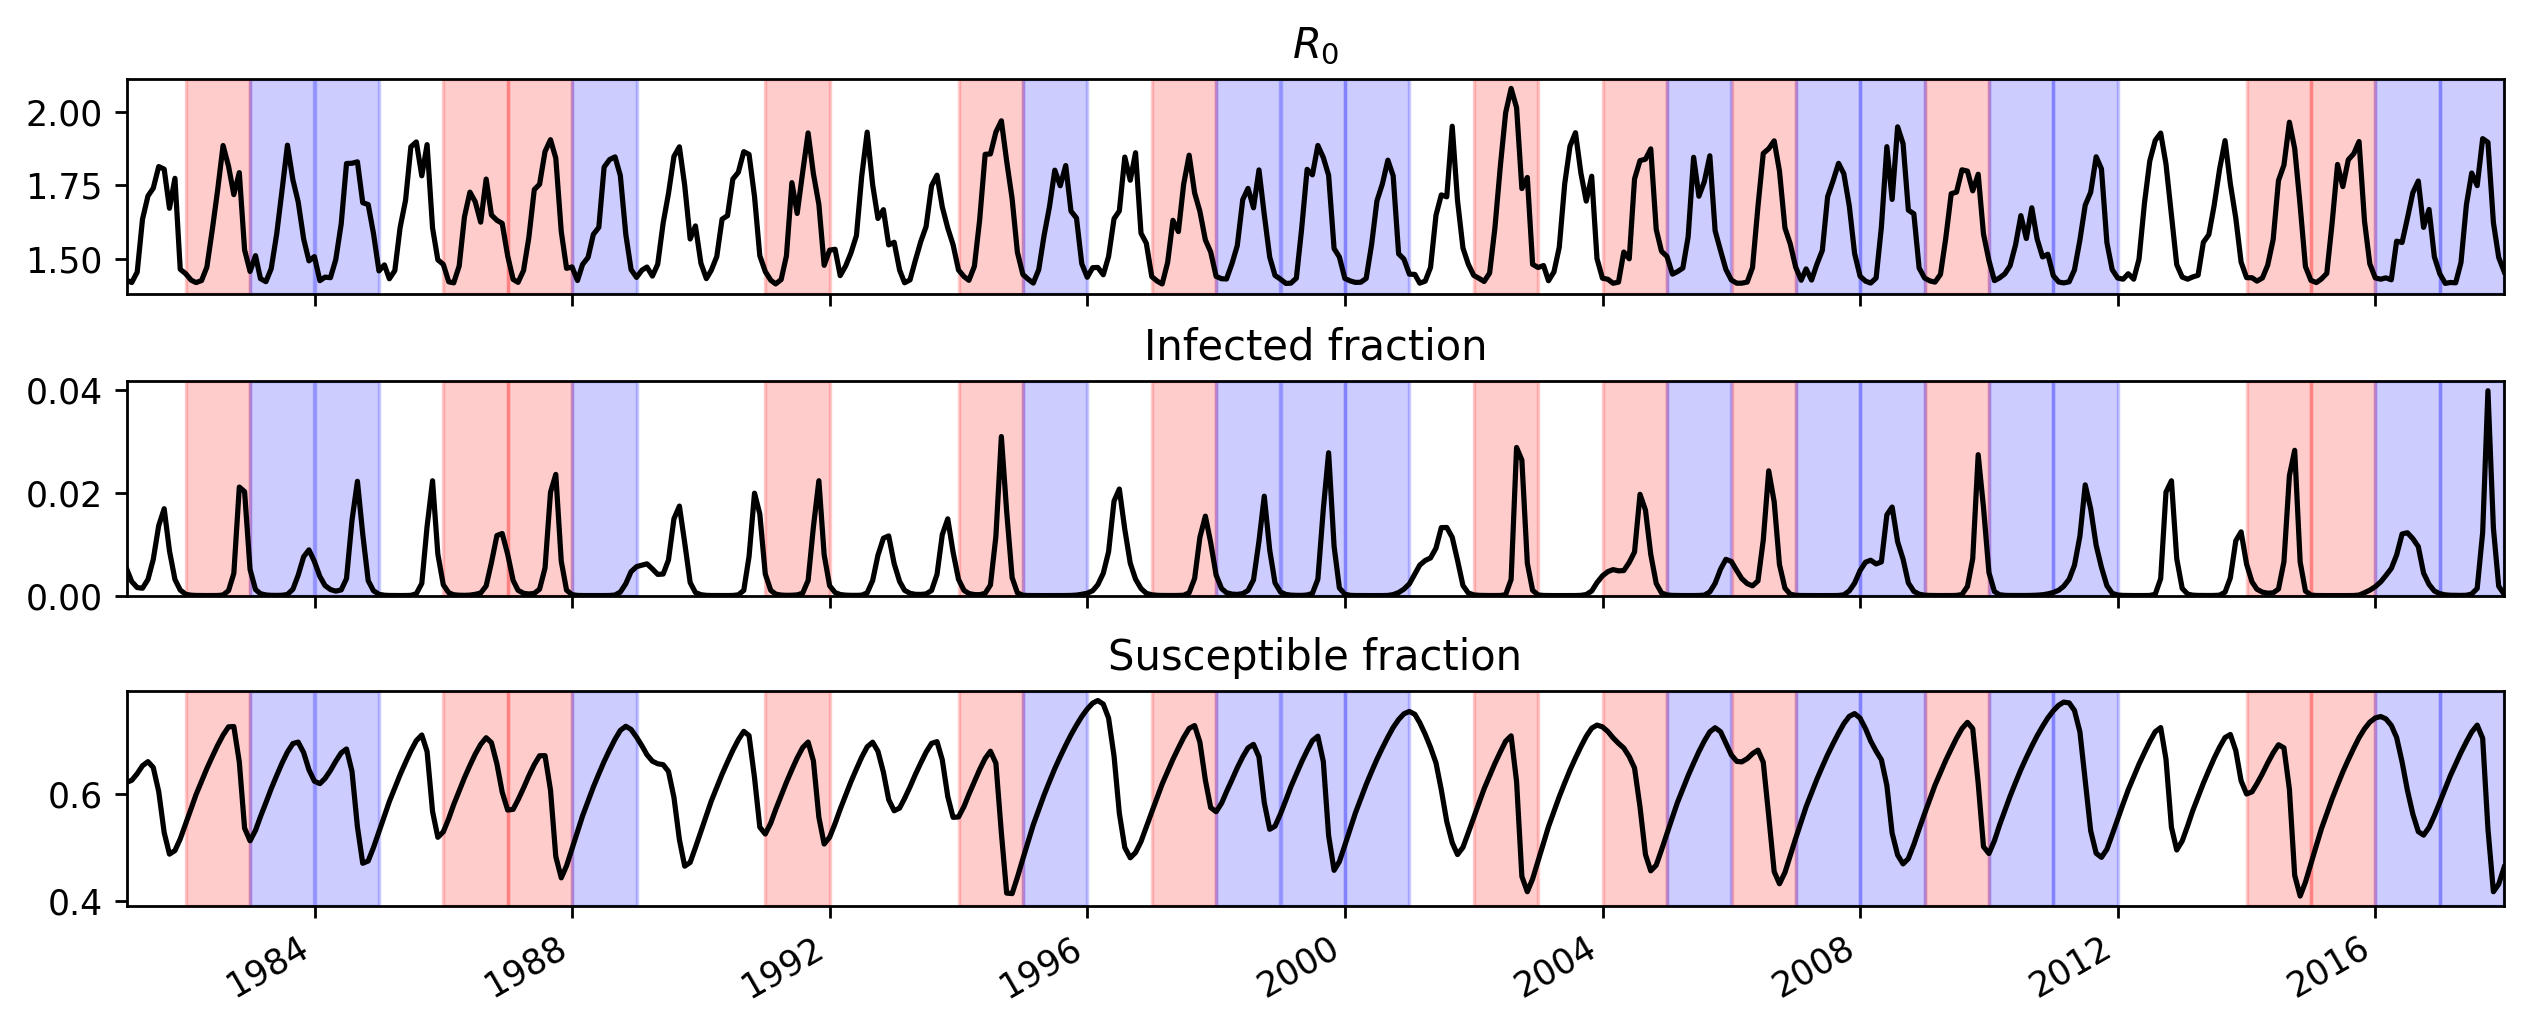

In [11]:
lon, lat = 128, -18 # choose a location

plot_comp_timeseries(lon, lat,
                         ElNino_comp_ts,LaNina_comp_ts,
                         ElNino_CI_ts,LaNina_CI_ts,
                        clim_ts, Neutral_comp_ts,location_name='NW Australia',neutral=False)

plot_ts_ENSOevents(lon,lat,
                       ds,
                       ElNino_allevents,LaNina_allevents)

# Rondônia, Brazil

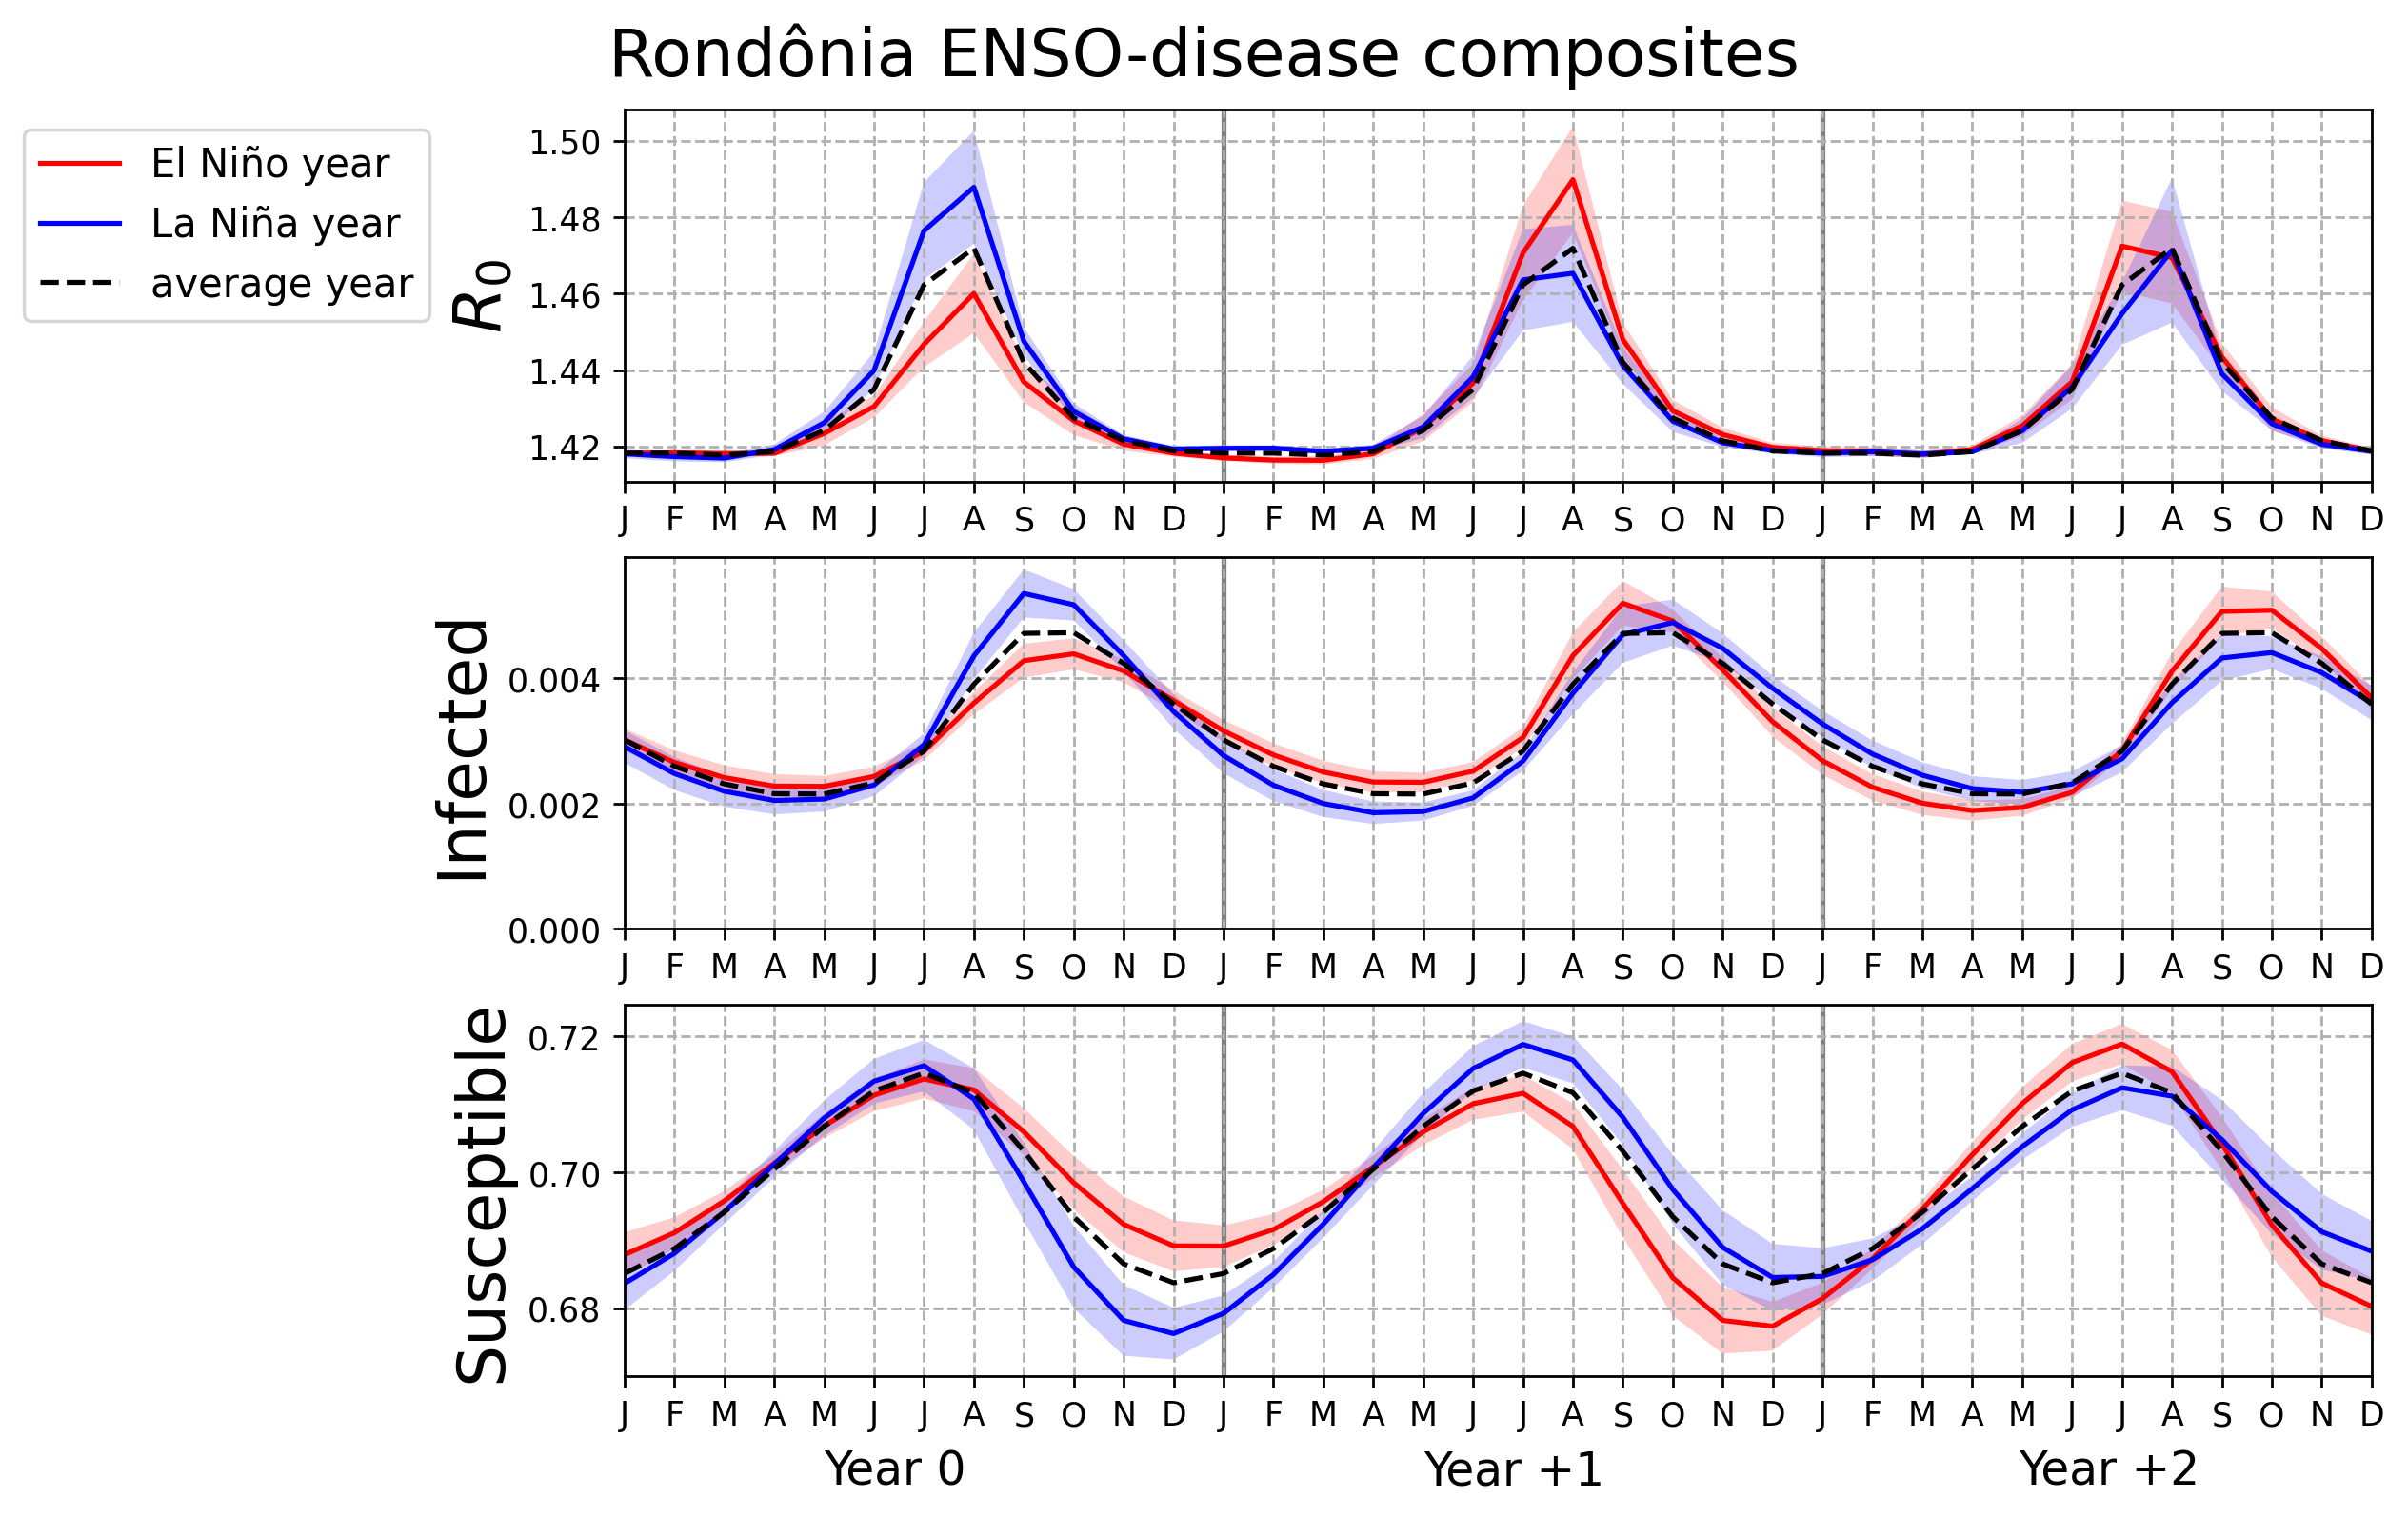

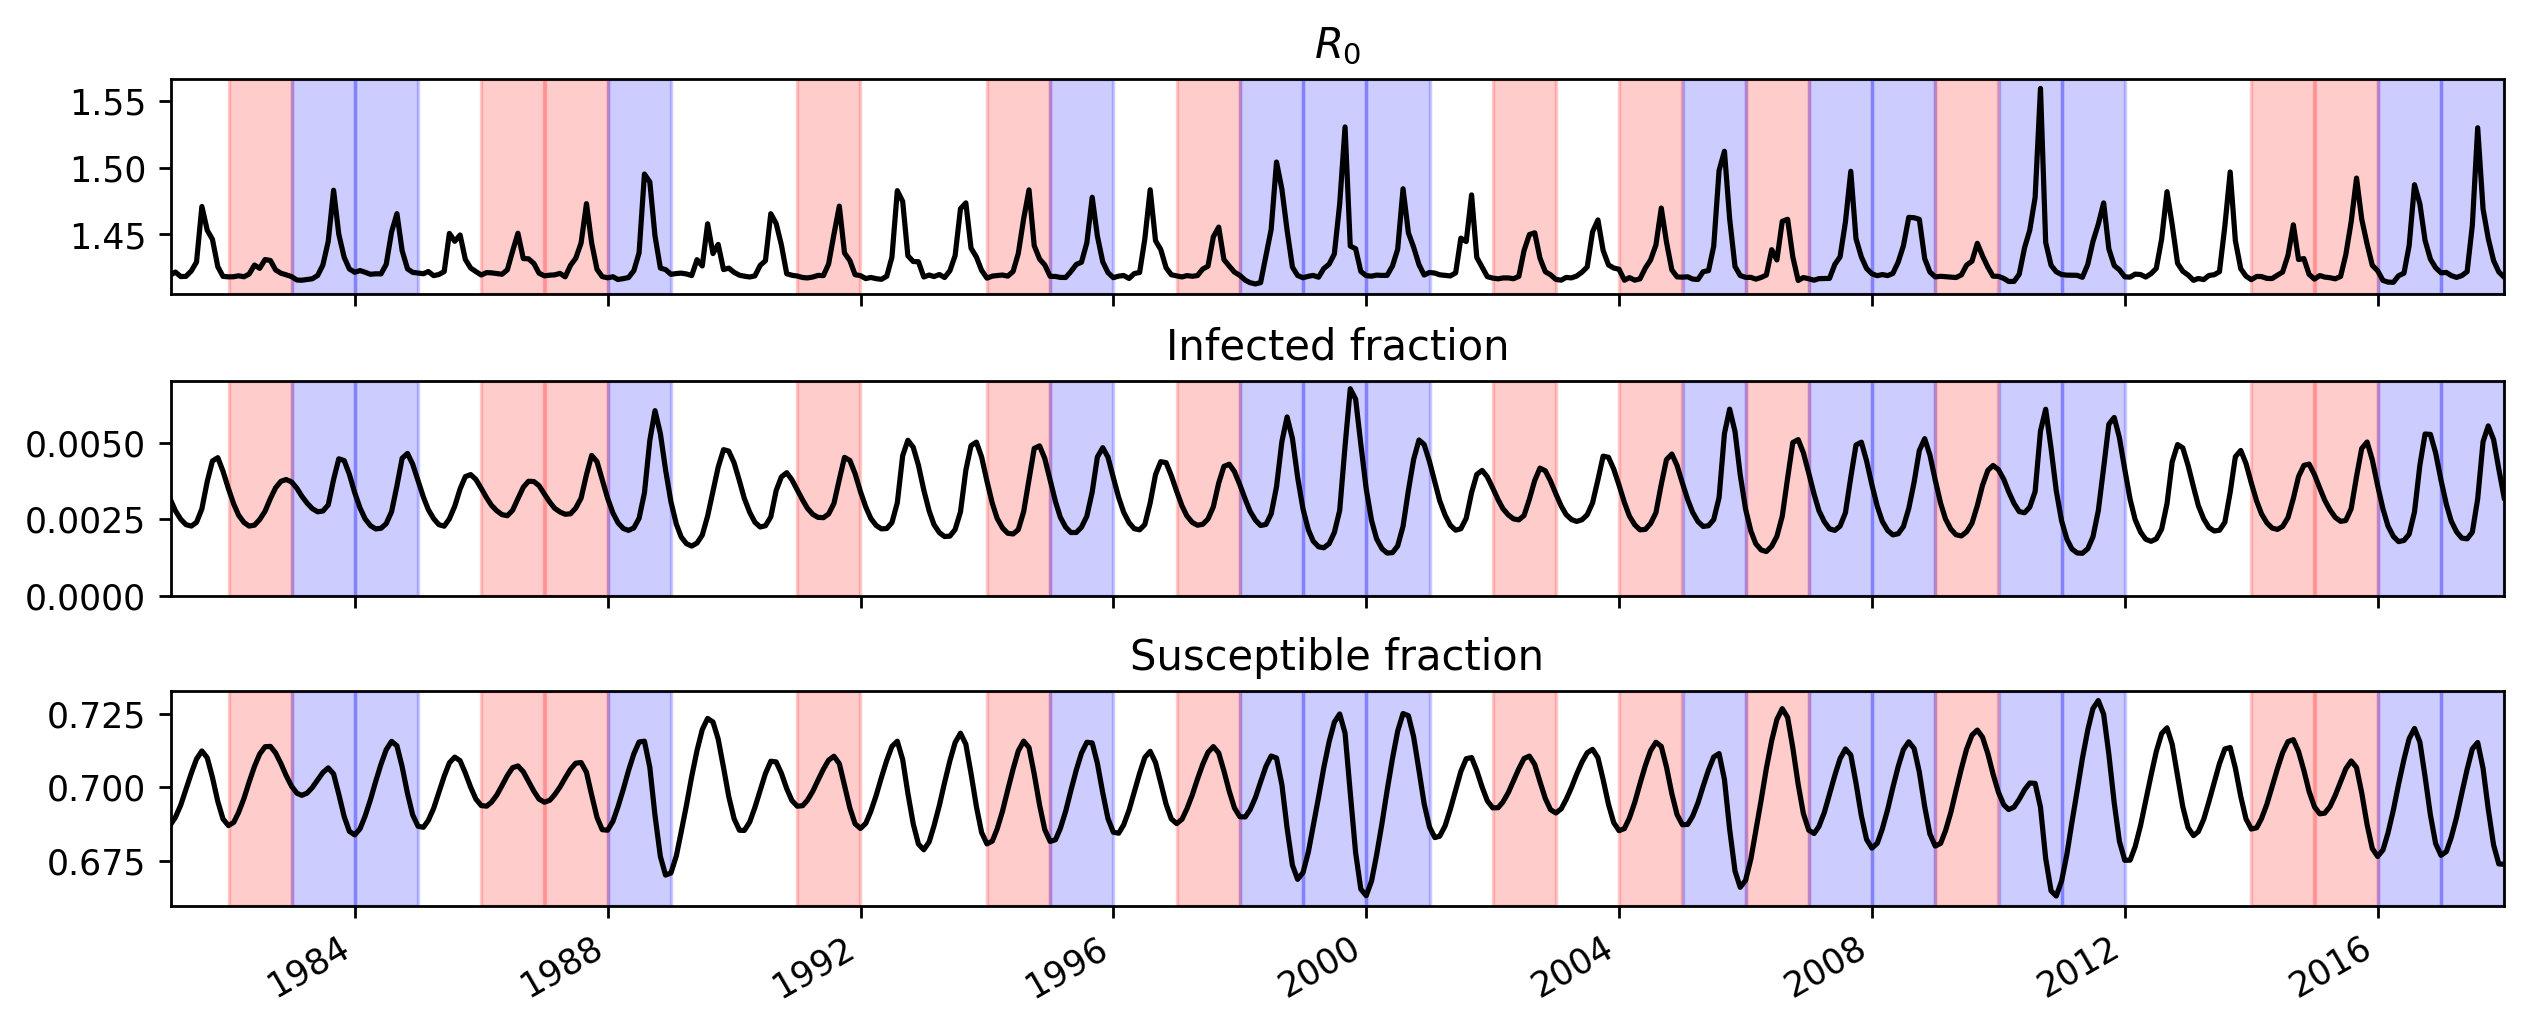

In [12]:
lon, lat = -63, -11 # choose a location

plot_comp_timeseries(lon, lat,
                         ElNino_comp_ts,LaNina_comp_ts,
                         ElNino_CI_ts,LaNina_CI_ts,
                        clim_ts, Neutral_comp_ts,location_name='Rondônia', neutral=False)

plot_ts_ENSOevents(lon,lat,
                       ds,
                       ElNino_allevents,LaNina_allevents)